In [1]:
#Includes necesarios
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report,plot_roc_curve

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import auxiliar as aux

from preprocessing import apply_OHE, init_OHE, init_dataset, reduce_by_frequency, eliminar_features

# **Arbol de Decisión**

Los hiperparametros que consideramos relevantes para el modelo Arbol de Decision son:
   - criterion: La funcion para medir la calidad de una particion.
   - max_depth: Profundidad maxima del arbol.
   - min_samples_leaf: El numero minimo de muestras requerido para que un nodo sea considerado como nodo hoja. 

Obtenemos el dataset con el cual entrenaremos nuestro modelo. Para este modelo se opto unicamente tratar los missings como categoricos:

In [2]:
X,y = aux.get_train_set()
X = init_dataset(X)

## Preprocesamiento 1: OHE

Primero vamos a entrenar nuestro arbol de decisión aplicando unicamente OHE a las columnas categóricas:

In [3]:
init_OHE(X)
X_ohe = apply_OHE(X)

Partimos nuestro set en *train* y *validation*, dejaremos un 20% de los datos para validación de nuestro entrenamiento:

In [4]:
X_train, X_validation, y_train, y_validation = train_test_split(X_ohe,y, test_size=0.2, stratify=y, random_state=0)

Buscamos los mejores hiperparametros para el arbol de decision con GridSearchCV.

    - La métrica que se utiliza para comparar los modelos obtenidos en cada iteracion es roc_auc_score.
    - El intervalo de max_depth para las metricas que se calculan siempre estuvo entre [1, 15], por lo que se limitan las opciones a esos valores.
    - El intervalo de min_samples_leaf tiene un paso de 50 valores ya que consideramos que una diferencia menor a este valor resulta ser irrelevante para las metricas que se calculan.


In [5]:
parameters = {
    'criterion': ["gini", "entropy"],
    'max_depth': np.arange(5, 16),
    'min_samples_leaf': np.arange(50, 151, 50),
}

clf = DecisionTreeClassifier(random_state=0)

gscv = GridSearchCV(
    clf, parameters, scoring='roc_auc',n_jobs=-1, cv=5, return_train_score=True
).fit(X_train, y_train)

In [6]:
print(f"Mejor score ROC-AUC en Entrenamiento: {gscv.best_score_}")
print(f"Mejores Parametros {gscv.best_params_}")

print(f"\nMejor score ROC-AUC en Validación: {gscv.score(X_validation, y_validation)}")

Mejor score ROC-AUC en Entrenamiento: 0.9053395162687885
Mejores Parametros {'criterion': 'gini', 'max_depth': 11, 'min_samples_leaf': 50}

Mejor score ROC-AUC en Validación: 0.9029466994077712


Armamos el modelo de arbol de decision con los hiperparametros calculados:

In [7]:
tree_columns = X_train.columns
model_tree_p1 = gscv.best_estimator_
model_tree_p1

DecisionTreeClassifier(max_depth=11, min_samples_leaf=50, random_state=0)

Predecimos con el validation set:

In [8]:
tree_predict = model_tree_p1.predict(X_validation)

**Metricas**

In [9]:
print(classification_report(y_validation, tree_predict))

              precision    recall  f1-score   support

           0       0.89      0.91      0.90      4945
           1       0.70      0.66      0.68      1568

    accuracy                           0.85      6513
   macro avg       0.80      0.79      0.79      6513
weighted avg       0.85      0.85      0.85      6513



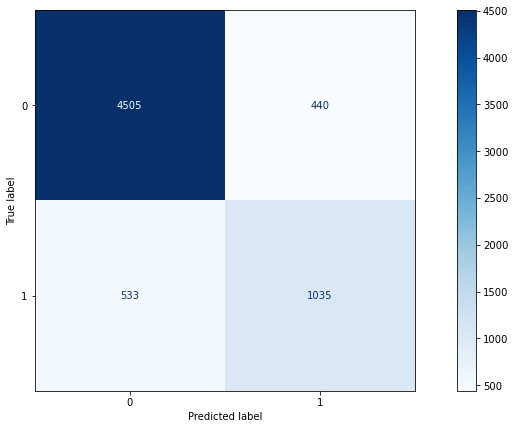

In [10]:
aux.plot_cm(model_tree_p1, X_validation, y_validation)

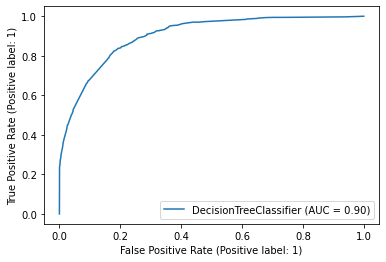

In [11]:
plot_roc_curve(model_tree_p1, X_validation, y_validation, response_method="predict_proba")
plt.show()

## Preprocesamiento 2: Reducción por frecuencia + OHE 

A diferencia del preprocesado anterior, ahora reduciremos por frecuencia de aparición algunas columnas dejando solo las categorias que tengan más del 15% de los datos y agrupando en una misma las demás. Luego aplicaremos OHE a las columnas categóricas. Al realizar este primer preproceso obtenemos una reduccion dimensional cuando apliquemos OHE. Las columnas que reduciremos son: 'Barrio', 'Religión', 'Categoría de Trabajo' y 'Estado Marital', que son features con categorias con muy pocos datos según lo analizado en el TP1

In [12]:
X_p2 = reduce_by_frequency(X, ['barrio', 'religion', 'categoria_de_trabajo', 'estado_marital'], 0.15)

In [13]:
init_OHE(X_p2)
X_p2 = apply_OHE(X_p2)

Partimos nuestro set en *train* y *validation*, dejaremos un 20% de los datos para validación de nuestro entrenamiento:

In [14]:
X_train, X_validation, y_train, y_validation = train_test_split(X_p2,y, test_size=0.2, stratify=y, random_state=0)

Buscamos los mejores hiperparametros para el arbol de decision con GridSearchCV. Nuevamente como en el preprocesado anterior:

    - La métrica que se utiliza para comparar los modelos obtenidos en cada iteracion es roc_auc_score.
    - El intervalo de max_depth para las metricas que se calculan siempre estuvo entre [5, 15], por lo que se limitan las opciones a esos valores.
    - El intervalo de min_samples_leaf tiene un paso de 50 valores ya que consideramos que una diferencia menor a este valor resulta ser irrelevante para las metricas que se calculan.

In [15]:
parameters = {
    'criterion': ["gini","entropy"],
    'max_depth': np.arange(5, 16),
    'min_samples_leaf': np.arange(50, 151, 50),
}

clf = DecisionTreeClassifier(random_state=0)

gscv = GridSearchCV(
    clf, parameters, scoring='roc_auc',n_jobs=-1, cv=5, return_train_score=True
).fit(X_train, y_train)

In [16]:
print(f"Mejor score ROC-AUC en Entrenamiento: {gscv.best_score_}")
print(f"Mejores Parametros {gscv.best_params_}")

print(f"\nMejor score ROC-AUC en Validación: {gscv.score(X_validation, y_validation)}")

Mejor score ROC-AUC en Entrenamiento: 0.9028119190419147
Mejores Parametros {'criterion': 'entropy', 'max_depth': 11, 'min_samples_leaf': 100}

Mejor score ROC-AUC en Validación: 0.9019959348754668


Armamos el modelo de arbol de decision con los hiperparametros calculados:

In [17]:
model_tree_p2 = gscv.best_estimator_
model_tree_p2

DecisionTreeClassifier(criterion='entropy', max_depth=11, min_samples_leaf=100,
                       random_state=0)

Predecimos con el validation set:

In [18]:
tree_predict = model_tree_p2.predict(X_validation)

**Metricas**

In [19]:
print(classification_report(y_validation, tree_predict))

              precision    recall  f1-score   support

           0       0.86      0.95      0.90      4945
           1       0.77      0.52      0.62      1568

    accuracy                           0.85      6513
   macro avg       0.82      0.73      0.76      6513
weighted avg       0.84      0.85      0.84      6513



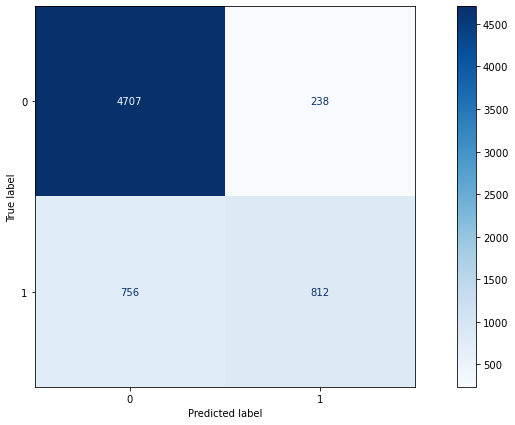

In [20]:
aux.plot_cm(model_tree_p2, X_validation, y_validation)

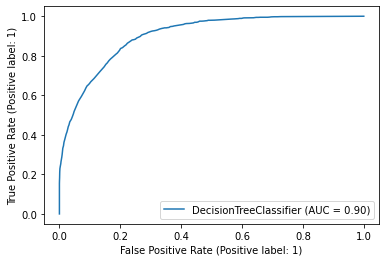

In [21]:
plot_roc_curve(model_tree_p2, X_validation, y_validation, response_method="predict_proba")
plt.show()

Al aplicar este nuevo preprocesamiento obtenemos una perdida de performance para predecir la clase con valor 1 de la variable objetivo.

## Preprocesamiento 3: Eliminación de Columnas + Reducción por frecuencia + OHE 

En este preprocesamiento eliminamos las columnas 'religion', 'barrio' y 'categoria de trabajo' ya que en el análisis del TP1 concluimos que no aportaban demasiada información. Además agrupamos las categorias que contienen menos del 5% de los datos, y finalmente aplicamos One Hot Encoding

In [22]:
X_p3 = eliminar_features(X, ['religion', 'barrio', 'categoria_de_trabajo'])
X_p3 = reduce_by_frequency(X_p3, ['estado_marital', 'trabajo'], 0.05)

In [23]:
init_OHE(X_p3)
X_p3 = apply_OHE(X_p3)

In [24]:
X_train, X_validation, y_train, y_validation = train_test_split(
    X_p3, y, random_state=0, test_size=0.2, stratify=y
)

In [25]:
parameters = {
    'criterion': ["gini", "entropy"],
    'max_depth': np.arange(5, 16),
    'min_samples_leaf': np.arange(50, 151, 50)
}

clf = DecisionTreeClassifier(random_state=0)

gscv = GridSearchCV(
    clf, parameters, scoring='roc_auc',n_jobs=-1, cv=5, return_train_score=True
).fit(X_train, y_train)

In [26]:
print(f"Mejor score ROC-AUC en Entrenamiento: {gscv.best_score_}")
print(f"Mejores Parametros {gscv.best_params_}")

print(f"\nMejor score ROC-AUC en Validación: {gscv.score(X_validation, y_validation)}")

Mejor score ROC-AUC en Entrenamiento: 0.9040383376958194
Mejores Parametros {'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 50}

Mejor score ROC-AUC en Validación: 0.9021651431047646


Armamos el modelo de arbol de decision con los hiperparametros calculados:

In [27]:
model_tree_p3 = gscv.best_estimator_
model_tree_p3

DecisionTreeClassifier(max_depth=9, min_samples_leaf=50, random_state=0)

Predecimos con el validation set:

In [28]:
tree_predict = model_tree_p3.predict(X_validation)

**Metricas**

In [29]:
print(classification_report(y_validation, tree_predict))

              precision    recall  f1-score   support

           0       0.86      0.95      0.91      4945
           1       0.78      0.53      0.63      1568

    accuracy                           0.85      6513
   macro avg       0.82      0.74      0.77      6513
weighted avg       0.84      0.85      0.84      6513



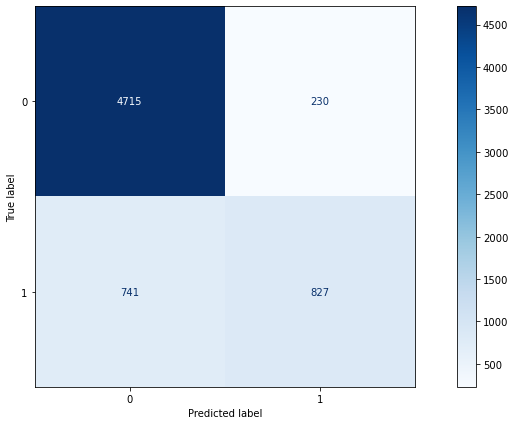

In [30]:
aux.plot_cm(model_tree_p3, X_validation, y_validation)

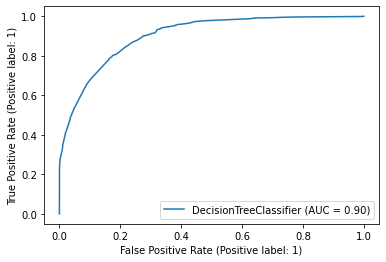

In [31]:
plot_roc_curve(model_tree_p3, X_validation, y_validation, response_method="predict_proba")
plt.show()

# Conclusión

Vimos que no hay mucha diferencia entre el primer preprocesamiento y el segundo preprocesamiento. A su vez, vimos que entrenando el arbol con los datos aplicandole unicamente OHE obtenemos un mejor resultado de la metrica AUC_ROC. Entonces nos quedaremos con el primer modelo. Una de las ventajas del arbol de deicision es que tiene facil interpretabilidad por lo que podemos mostrar como se visualiza este arbol obtenido:

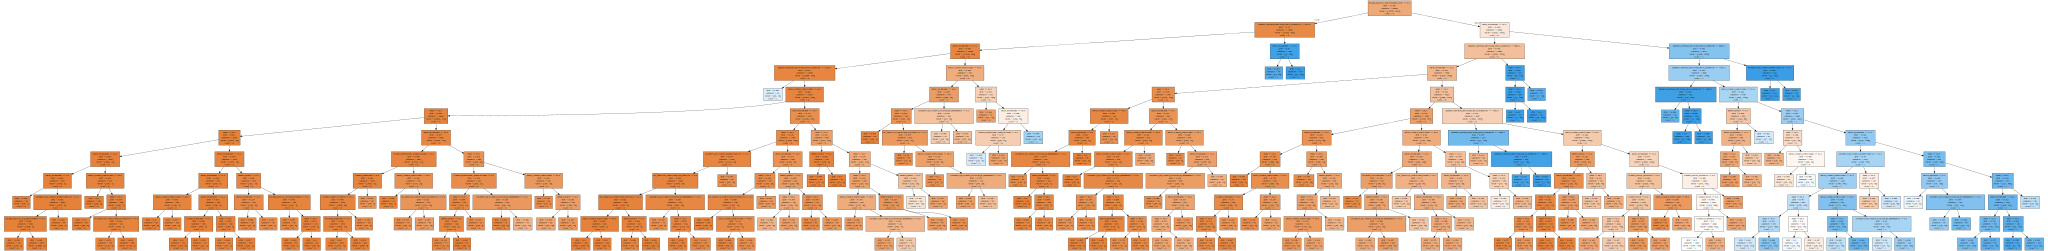

In [32]:
aux.plot_tree(model_tree_p1,tree_columns)

# Predicción

Por ultimo, con nuestro mejor modelo obtenido realizaremos una prediccion para datos que nunca vio en el entrenamiento ni en validación.

In [33]:
ids, X_holdout = aux.get_holdout_set()

In [34]:
X_holdout = init_dataset(X_holdout)

In [35]:
init_OHE(X)
X_holdout_ohe = apply_OHE(X_holdout)

In [36]:
tree_predict = model_tree_p1.predict(X_holdout_ohe)

In [37]:
aux.create_prediction(ids,tree_predict,file_name='arbol_decision')